- https://projecteuclid.org/journals/annals-of-statistics/volume-25/issue-6/Optimal-pointwise-adaptive-methods-in-nonparametric-estimation/10.1214/aos/1030741083.full

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

In [6]:
from statsmodels.nonparametric.kde import KDEUnivariate

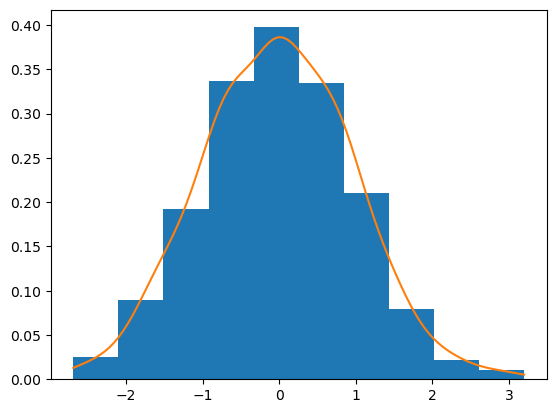

In [45]:
import numpy as np
data = np.random.randn(1000)
kde = KDEUnivariate(data)
kde = kde.fit()
x = np.linspace(min(data), max(data), num=100)
plt.hist(data, density=True)
plt.plot(x, kde.evaluate(x))

In [47]:
from sklearn.neighbors import KernelDensity

# Generate some data
import numpy as np
data = np.random.randn(100)

# Estimate the density using KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data[:, np.newaxis])

# Calculate the density and confidence interval at a specific point
x = np.array([0.5])
density = np.exp(kde.score_samples(x.reshape(1, -1)))
confidence_interval = kde.confidence_interval(data.reshape(1, -1))

print(f"Density at {x}: {density}")
print(f"Confidence interval: {confidence_interval}")

AttributeError: 'KernelDensity' object has no attribute 'confidence_interval'

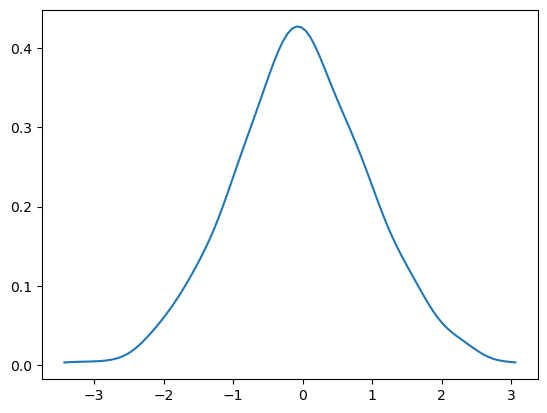